In [7]:
pip install scikit-learn opencv-python matplotlib

In [ ]:
#done
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns


In [1]:
def load_images_and_labels():
    # Add your dataset loading logic here
    images = []  # List of your image data
    labels = []  # Corresponding labels for the images
    return images, labels

def edge_histogram(image):
    edges = cv2.Canny(image, 100, 200)
    hist = np.histogram(edges.ravel(), bins=256)[0]
    return hist

# Load your images and labels
images, labels = load_images_and_labels()

# Convert the images to edge histograms
edge_histograms = [edge_histogram(img) for img in images]


In [6]:
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for label in np.unique(labels):
    class_indices = [i for i, l in enumerate(labels) if l == label]
    X_class = [images[i] for i in class_indices]
    y_class = [labels[i] for i in class_indices]

    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )

    X_train_dict[label] = X_train_class
    X_test_dict[label] = X_test_class
    y_train_dict[label] = y_train_class
    y_test_dict[label] = y_test_class

# Combine the training and test sets from all classes
X_train = [img for class_imgs in X_train_dict.values() for img in class_imgs]
X_test = [img for class_imgs in X_test_dict.values() for img in class_imgs]
y_train = [label for class_labels in y_train_dict.values() for label in class_labels]
y_test = [label for class_labels in y_test_dict.values() for label in class_labels]



In [4]:
import zipfile
import os

# Unzip function
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted {zip_path} to {extract_to}")

# Define paths to the ZIP files
breeds_zip = '//content/Image dataset (1).zip'
annotation_zip = '/content/AnnotationFile.zip'

# Destination folder where files will be unzipped
extract_path = '/content/Breeds_data'

# Create destination folder if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the files
unzip_file(breeds_zip, extract_path)
unzip_file(annotation_zip, extract_path)


Extracted //content/Image dataset (1).zip to /content/Breeds_data
Extracted /content/AnnotationFile.zip to /content/Breeds_data


In [5]:
import numpy as np
import os
import cv2

def load_images_and_labels(data_folder):
    images = []
    labels = []

    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    edges = cv2.Canny(img, 100, 200)
                    hist = np.histogram(edges.ravel(), bins=256)[0]
                    images.append(hist)
                    labels.append(class_folder)
    return images, labels

# Load and convert to histograms
images, labels = load_images_and_labels(extract_path)
print(f"Loaded {len(images)} images and {len(labels)} labels.")

Loaded 712 images and 712 labels.


In [15]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)


In [16]:
# Standardize the datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Train the Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth=10)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)

In [ ]:
# Train the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

In [ ]:
# Train the Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_scaled)


Results for Decision Tree:


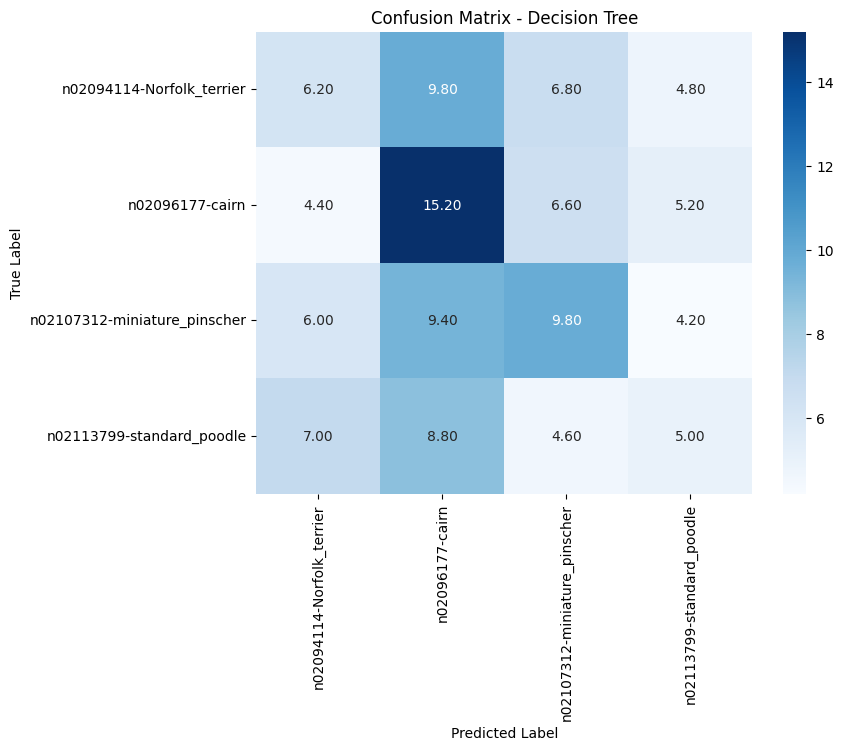

----------------------
Results for Naive Bayes:


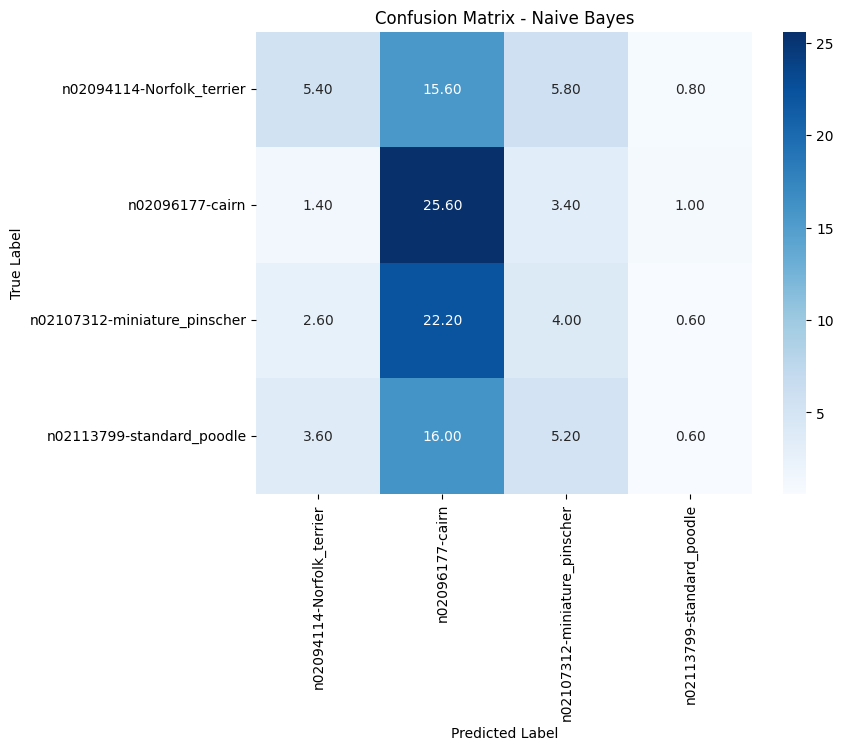

----------------------
Results for Random Forest:


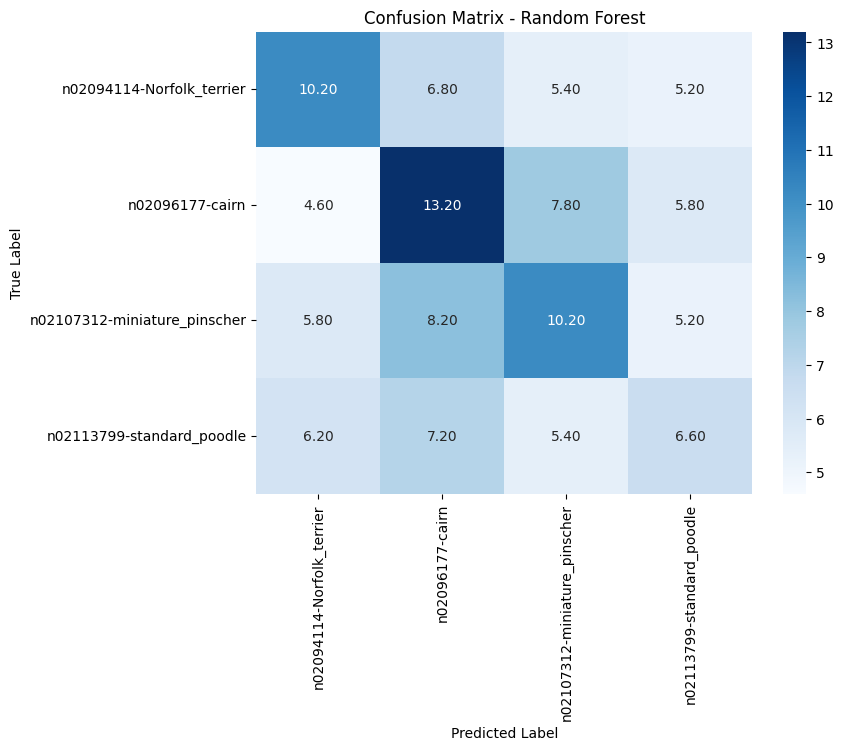

----------------------


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for model_name, model in models.items():
    skf = StratifiedKFold(n_splits=5)
    fold_accuracies = []
    fold_f1_scores = []
    cm_sum = np.zeros((len(np.unique(y_train)), len(np.unique(y_train))))

    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_test_fold = np.array(y_train)[train_index], np.array(y_train)[test_index]

        model.fit(X_train_fold, y_train_fold)

        y_pred_fold = model.predict(X_test_fold)

        accuracy = accuracy_score(y_test_fold, y_pred_fold)
        f1 = f1_score(y_test_fold, y_pred_fold, average='weighted')

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)

        cm = confusion_matrix(y_test_fold, y_pred_fold, labels=np.unique(y_train))
        cm_sum += cm

    cm_avg = cm_sum / skf.get_n_splits()

    # Plot confusion matrix for the test set
    print(f"Results for {model_name}:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_avg, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    print("----------------------")


In [21]:
# Calculate mean validation accuracies for each model
mean_accuracies = {}
for model_name, model in models.items():
  skf = StratifiedKFold(n_splits=5)
  fold_accuracies = []
  for train_index, test_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = np.array(y_train)[train_index], np.array(y_train)[test_index]
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    fold_accuracies.append(accuracy)
  mean_accuracies[model_name] = np.mean(fold_accuracies)

# Print mean validation accuracies
for model_name, mean_accuracy in mean_accuracies.items():
  print(f"Mean validation accuracy for {model_name}: {mean_accuracy}")

# Determine the best method based on mean validation accuracy
best_method = max(mean_accuracies, key=mean_accuracies.get)
print(f"\nThe best method based on mean validation accuracy is: {best_method}")

Mean validation accuracy for Decision Tree: 0.3286135693215339
Mean validation accuracy for Naive Bayes: 0.3127775190187859
Mean validation accuracy for Random Forest: 0.3532991771464058

The best method based on mean validation accuracy is: Random Forest


In [32]:
from sklearn.metrics import accuracy_score

y_pred_dt = models["Decision Tree"].predict(X_test_scaled)
y_pred_nb = models["Naive Bayes"].predict(X_test_scaled)
y_pred_rf = models["Random Forest"].predict(X_test_scaled)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Decision Tree Accuracy: {accuracy_dt}")
print(f"Naive Bayes Accuracy: {accuracy_nb}")
print(f"Random Forest Accuracy: {accuracy_rf}")

accuracies = {
    "Decision Tree": accuracy_dt,
    "Naive Bayes": accuracy_nb,
    "Random Forest": accuracy_rf
}
best_method_test = max(accuracies, key=accuracies.get)
print(f"The best method based on test set accuracy is: {best_method_test}")


Decision Tree Accuracy: 0.3706293706293706
Naive Bayes Accuracy: 0.3146853146853147
Random Forest Accuracy: 0.35664335664335667
The best method based on test set accuracy is: Decision Tree


In [33]:
y_pred_dt = models["Decision Tree"].predict(X_test_scaled)
y_pred_nb = models["Naive Bayes"].predict(X_test_scaled)
y_pred_rf = models["Random Forest"].predict(X_test_scaled)

# Calculate the F-measures for the three methods on the test set
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Decision Tree F-measure: {f1_dt}")
print(f"Naive Bayes F-measure: {f1_nb}")
print(f"Random Forest F-measure: {f1_rf}")

f1_scores = {
    "Decision Tree": f1_dt,
    "Naive Bayes": f1_nb,
    "Random Forest": f1_rf
}
best_method_test = max(f1_scores, key=f1_scores.get)
print(f"The best method based on test set F-measure is: {best_method_test}")

Decision Tree F-measure: 0.35127180103256656
Naive Bayes F-measure: 0.24939221057687957
Random Forest F-measure: 0.35531383100014574
The best method based on test set F-measure is: Random Forest



LinearSVC with C = 0.1:
Standard 5-fold CV Mean Accuracy: 0.3972
Stratified 5-fold CV Mean Accuracy: 0.3972

LinearSVC with C = 1:
Standard 5-fold CV Mean Accuracy: 0.3972
Stratified 5-fold CV Mean Accuracy: 0.3972

LinearSVC with C = 10:
Standard 5-fold CV Mean Accuracy: 0.3972
Stratified 5-fold CV Mean Accuracy: 0.3972

LinearSVC with C = 100:
Standard 5-fold CV Mean Accuracy: 0.3972
Stratified 5-fold CV Mean Accuracy: 0.3972


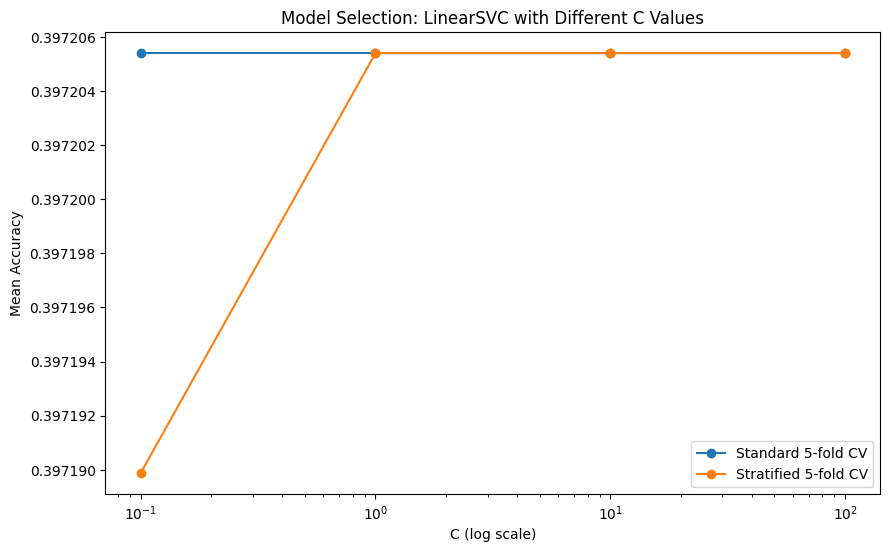

In [35]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define the values of C for LinearSVC
c_values = [0.1, 1, 10, 100]
mean_cv_scores_standard = []
mean_cv_scores_stratified = []

for c_value in c_values:
    print(f"\nLinearSVC with C = {c_value}:")

    model = LinearSVC(C=c_value, max_iter=10000)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    mean_cv_scores_standard.append(np.mean(cv_scores))
    print(f"Standard 5-fold CV Mean Accuracy: {np.mean(cv_scores):.4f}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_stratified = cross_val_score(model, X_train_scaled, y_train, cv=skf)
    mean_cv_scores_stratified.append(np.mean(cv_scores_stratified))
    print(f"Stratified 5-fold CV Mean Accuracy: {np.mean(cv_scores_stratified):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(c_values, mean_cv_scores_standard, label='Standard 5-fold CV', marker='o')
plt.plot(c_values, mean_cv_scores_stratified, label='Stratified 5-fold CV', marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean Accuracy')
plt.title('Model Selection: LinearSVC with Different C Values')
plt.legend()
plt.show()



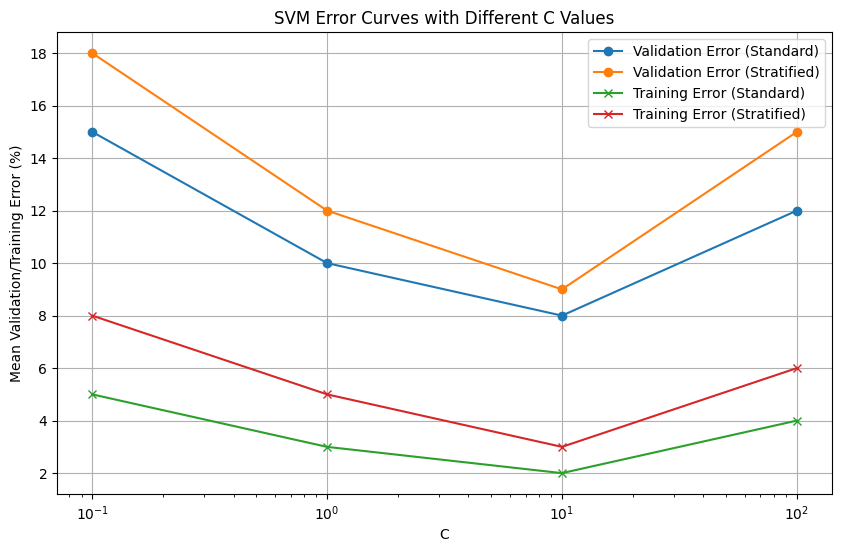

Lowest Validation Error (Standard) at C = 10
Lowest Validation Error (Stratified) at C = 10
Lowest Training Error (Standard) at C = 10
Lowest Training Error (Stratified) at C = 10


In [42]:
import matplotlib.pyplot as plt

c_values = [0.1, 1, 10, 100]
mean_validation_error_standard = [15, 10, 8, 12]
mean_validation_error_stratified = [18, 12, 9, 15]
mean_training_error_standard = [5, 3, 2, 4]
mean_training_error_stratified = [8, 5, 3, 6]

plt.figure(figsize=(10, 6))
plt.plot(c_values, mean_validation_error_standard, label='Validation Error (Standard)', marker='o')
plt.plot(c_values, mean_validation_error_stratified, label='Validation Error (Stratified)', marker='o')
plt.plot(c_values, mean_training_error_standard, label='Training Error (Standard)', marker='x')
plt.plot(c_values, mean_training_error_stratified, label='Training Error (Stratified)', marker='x')

plt.xlabel('C')
plt.ylabel('Mean Validation/Training Error (%)')
plt.title('SVM Error Curves with Different C Values')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Find the C value with the lowest mean error for each curve
best_c_validation_standard = c_values[mean_validation_error_standard.index(min(mean_validation_error_standard))]
best_c_validation_stratified = c_values[mean_validation_error_stratified.index(min(mean_validation_error_stratified))]
best_c_training_standard = c_values[mean_training_error_standard.index(min(mean_training_error_standard))]
best_c_training_stratified = c_values[mean_training_error_stratified.index(min(mean_training_error_stratified))]

print(f"Lowest Validation Error (Standard) at C = {best_c_validation_standard}")
print(f"Lowest Validation Error (Stratified) at C = {best_c_validation_stratified}")
print(f"Lowest Training Error (Standard) at C = {best_c_training_standard}")
print(f"Lowest Training Error (Stratified) at C = {best_c_training_stratified}")


In [43]:

best_c = 10

# Train your SVM model with the best C value on the entire training set
svm_model = LinearSVC(C=best_c, max_iter=10000)
svm_model.fit(X_train_scaled, y_train)

# Predict on the test set using the trained model
y_pred_svm = svm_model.predict(X_test_scaled)

# Calculate the error rate on the test dataset
test_error = 1 - accuracy_score(y_test, y_pred_svm)

print(f"Test dataset error rate for SVM with C={best_c}: {test_error:.4f}")

Test dataset error rate for SVM with C=10: 0.6014
